For this example I am going to use the classic Boston housing dataset.  The dataset was created by writing the dataset from R MASS package to CSV.

In [10]:
# http://www.stat.columbia.edu/~gelman/research/published/priors11.pdf
# run to install most recent version
#! pip install git+https://github.com/pysr1/pymc3_models.git --upgrade

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from pymc3 import summary, traceplot
from pymc3_models.models.LinearRegression import LinearRegression
import seaborn as sns 

df = pd.read_csv('data/boston.csv')

df['lstat'] = np.log1p(df['lstat'])
df['nox'] = np.log1p(df['nox'])
df['dis'] = np.log1p(df['dis'])

Look at the first few rows:

/anaconda3/envs/Main/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


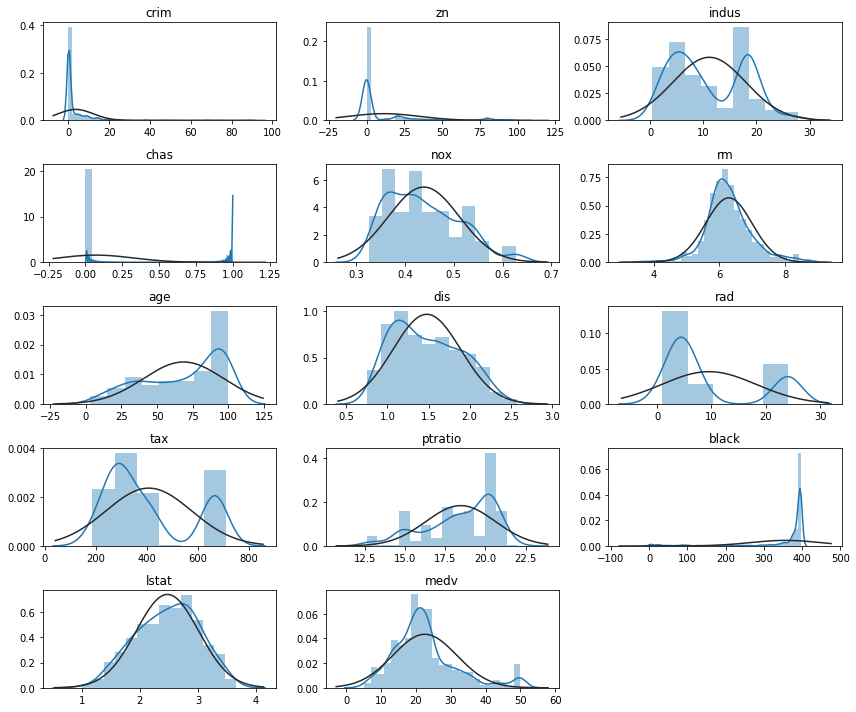

In [11]:
from scipy.stats import norm 
fig, ax = plt.subplots(5, 3, figsize = (12, 10))
ax = ax.ravel()
j = 0
for i in df.columns:
    sns.distplot(df[i], ax = ax[j], fit = norm)
    ax[j].set_title(i)
    ax[j].set_xlabel("")
    j += 1
ax[14].axis('off')
plt.tight_layout()
plt.show()

Skew:

In [15]:
skew = pd.DataFrame(df.skew())
skew.T

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,5.223149,2.225666,0.295022,3.405904,0.584347,0.403612,-0.598963,0.331561,1.004815,0.669956,-0.802325,-2.890374,-0.187195,1.108098


multicolinearity is present!

In [4]:
#https://etav.github.io/python/vif_factor_python.html
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif = vif.set_index(df.columns)
vif.T


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
VIF Factor,2.139357,2.597997,14.738775,1.176103,122.364639,155.761431,23.317961,54.884851,15.514808,62.10204,103.292549,21.794635,76.513014,25.923894


We can see this in the clustermap:

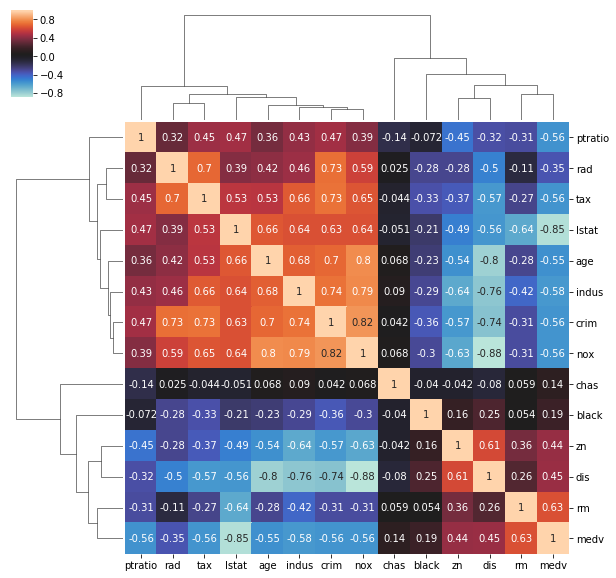

In [9]:
# use spearman correlation because of distributions
sns.clustermap(df.corr(method = 'spearman'), annot = True,
              center = np.median(df.corr(method = 'spearman')))
plt.show()

Classic OLS regrssion often fails when multicolinearity is present.  Frequentists will often use regularization (l1, l2, elastic net) to shrink the weights of cofficients towards 0 to deal wih issue and improve predictive performance.  

In the presence of many correlated variables (or many variables in general) bayesians regularize with the prior they put on the coefficient.

In [6]:
# explanation of prior https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('medv', 1)
y = np.log(df['medv'])

X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

LR = LinearRegression()
LR.fit(X_train, y_train, inference_type = 'nuts', scale = 1,
      dof = 3)

LR.score(X_test, y_test)

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, coefficients, intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:13<00:00, 720.73draws/s]
The acceptance probability does not match the target. It is 0.8815489016770707, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2

0.8148488658709373

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

LR = LinearRegression()
# I prefer this prior for regression coefficients 
# It works better in this situation 
LR.fit(X_train, y_train, inference_type = 'nuts', scale = 1,
      dof = 7)

LR.score(X_test, y_test)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, coefficients, intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:13<00:00, 735.69draws/s]
The acceptance probability does not match the target. It is 0.8823540646901384, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823668160567932, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:23<00:00, 83.74it/s] 


0.8146542061287765

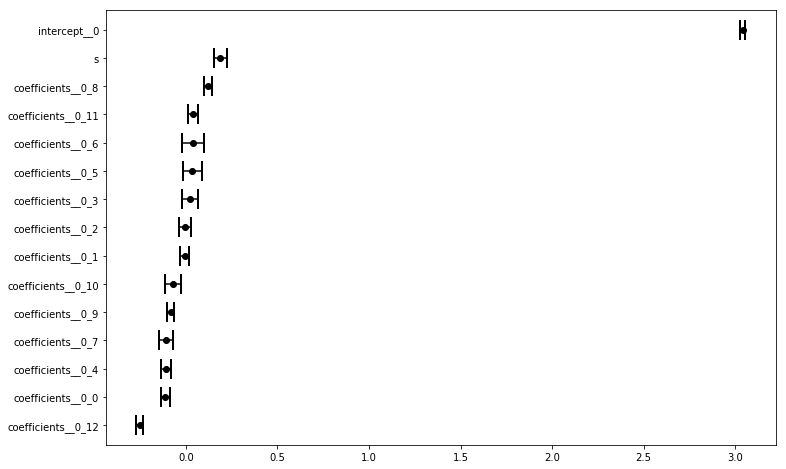

In [23]:
coefs = LR.summary.reset_index().rename(columns = {'index' : 'coef'})
ypa_ci = np.array(list(zip(-coefs['hpd_2.5'] + coefs['mean'], 
                            coefs['hpd_97.5'] - coefs['mean']))).T

coefs = coefs.sort_values('mean')
plt.figure(figsize = (12, 8))
plt.errorbar('mean', 'coef', xerr=ypa_ci, data=coefs, fmt='ko', 
             capthick=2, capsize=10, label=None)
plt.show()

,coef,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
13,coefficients__0_12,-0.251551,0.017401,0.000218,-0.284107,-0.216073,6667.779042,1.000119
1,coefficients__0_0,-0.111121,0.012643,0.000130,-0.135816,-0.086707,8312.942390,0.999784
5,coefficients__0_4,-0.109942,0.022162,0.000280,-0.151529,-0.065483,6890.699231,1.000048
8,coefficients__0_7,-0.106503,0.021559,0.000257,-0.149658,-0.064956,6640.665671,0.999983
10,coefficients__0_9,-0.083222,0.030118,0.000464,-0.140404,-0.023066,4885.271700,1.000059
11,coefficients__0_10,-0.071050,0.012718,0.000149,-0.094567,-0.044793,7763.235983,1.000083
2,coefficients__0_1,-0.006814,0.014126,0.000165,-0.034683,0.021095,7876.257462,0.999837
3,coefficients__0_2,-0.003042,0.019791,0.000212,-0.041736,0.035204,7336.844924,0.999909
4,coefficients__0_3,0.023918,0.009990,0.000110,0.004555,0.043573,9778.051661,0.999878
6,coefficients__0_5,0.032918,0.013517,0.000151,0.006390,0.058906,7224.394275,0.999813


In [8]:
# I keep forgetting where this is on my computer 
import pymc3_models
print(pymc3_models.__file__)

/anaconda3/envs/Main/lib/python3.6/site-packages/pymc3_models/__init__.py
